In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 8000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)

    # Output, class prediction
    fc3 = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(fc3.shape)
    return fc3

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # 512 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 357300288.000000, Accuracy = 0.0899999961257
Performance on test set: Training epochs #1000, Batch Loss = 207295488.0, Accuracy = 0.0
Training epochs #20000: Batch Loss = 273063584.000000, Accuracy = 0.149000003934
Performance on test set: Training epochs #20000, Batch Loss = 262956384.0, Accuracy = 0.035000000149
Training epochs #40000: Batch Loss = 293361088.000000, Accuracy = 0.0329999998212
Performance on test set: Training epochs #40000, Batch Loss = 110375920.0, Accuracy = 0.0380000025034
Training epochs #60000: Batch Loss = 148345184.000000, Accuracy = 0.180000007153
Performance on test set: Training epochs #60000, Batch Loss = 4780975.0, Accuracy = 0.942999958992
Training epochs #80000: Batch Loss = 72848152.000000, Accuracy = 0.486000001431
Performance on test set: Training epochs #80000, Batch Loss = 23546252.0, Accuracy = 0.809000015259
Training epochs #100000: Batch Loss = 207566032.000000, Accuracy = 0.127000004053
Performance on test se

Training epochs #920000: Batch Loss = 10998770.000000, Accuracy = 0.706000030041
Performance on test set: Training epochs #920000, Batch Loss = 2114905.5, Accuracy = 0.954999983311
Training epochs #940000: Batch Loss = 7464631.500000, Accuracy = 0.823000073433
Performance on test set: Training epochs #940000, Batch Loss = 2920058.5, Accuracy = 0.955000042915
Training epochs #960000: Batch Loss = 5259582.500000, Accuracy = 0.865000069141
Performance on test set: Training epochs #960000, Batch Loss = 3469665.75, Accuracy = 0.942999958992
Training epochs #980000: Batch Loss = 41871784.000000, Accuracy = 0.312000006437
Performance on test set: Training epochs #980000, Batch Loss = 2087159.625, Accuracy = 0.955000042915
Training epochs #1000000: Batch Loss = 8532748.000000, Accuracy = 0.728000044823
Performance on test set: Training epochs #1000000, Batch Loss = 1896108.625, Accuracy = 0.955000042915
Training epochs #1020000: Batch Loss = 6711848.500000, Accuracy = 0.8259999156
Performance 

Training epochs #1820000: Batch Loss = 2323810.000000, Accuracy = 0.894000053406
Performance on test set: Training epochs #1820000, Batch Loss = 835909.9375, Accuracy = 0.961000084877
Training epochs #1840000: Batch Loss = 1443913.625000, Accuracy = 0.926999986172
Performance on test set: Training epochs #1840000, Batch Loss = 972520.8125, Accuracy = 0.961000025272
Training epochs #1860000: Batch Loss = 16132636.000000, Accuracy = 0.46099999547
Performance on test set: Training epochs #1860000, Batch Loss = 556066.1875, Accuracy = 0.961000025272
Training epochs #1880000: Batch Loss = 2796200.250000, Accuracy = 0.837999999523
Performance on test set: Training epochs #1880000, Batch Loss = 531595.4375, Accuracy = 0.967999994755
Training epochs #1900000: Batch Loss = 2655722.750000, Accuracy = 0.87399995327
Performance on test set: Training epochs #1900000, Batch Loss = 766595.9375, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 1452435.250000, Accuracy = 0.929000020027


Training epochs #2720000: Batch Loss = 741494.500000, Accuracy = 0.950000047684
Performance on test set: Training epochs #2720000, Batch Loss = 246159.09375, Accuracy = 0.967999994755
Training epochs #2740000: Batch Loss = 8492379.000000, Accuracy = 0.577000021935
Performance on test set: Training epochs #2740000, Batch Loss = 227810.34375, Accuracy = 0.991000056267
Training epochs #2760000: Batch Loss = 977605.625000, Accuracy = 0.934000074863
Performance on test set: Training epochs #2760000, Batch Loss = 234236.125, Accuracy = 0.991000056267
Training epochs #2780000: Batch Loss = 1074890.750000, Accuracy = 0.931000053883
Performance on test set: Training epochs #2780000, Batch Loss = 211369.40625, Accuracy = 0.990000009537
Training epochs #2800000: Batch Loss = 567186.000000, Accuracy = 0.949000060558
Performance on test set: Training epochs #2800000, Batch Loss = 216506.546875, Accuracy = 0.982000112534
Training epochs #2820000: Batch Loss = 6967391.500000, Accuracy = 0.63800001144

Training epochs #3620000: Batch Loss = 3507870.500000, Accuracy = 0.733999967575
Performance on test set: Training epochs #3620000, Batch Loss = 117855.625, Accuracy = 0.991000056267
Training epochs #3640000: Batch Loss = 356173.406250, Accuracy = 0.958999991417
Performance on test set: Training epochs #3640000, Batch Loss = 139474.96875, Accuracy = 0.991000056267
Training epochs #3660000: Batch Loss = 386851.531250, Accuracy = 0.963999986649
Performance on test set: Training epochs #3660000, Batch Loss = 120633.960938, Accuracy = 0.991000056267
Training epochs #3680000: Batch Loss = 243970.687500, Accuracy = 0.975000023842
Performance on test set: Training epochs #3680000, Batch Loss = 110008.664062, Accuracy = 0.991000056267
Training epochs #3700000: Batch Loss = 3364279.000000, Accuracy = 0.739000022411
Performance on test set: Training epochs #3700000, Batch Loss = 111722.859375, Accuracy = 0.991000056267
Training epochs #3720000: Batch Loss = 364197.781250, Accuracy = 0.9620000720

Training epochs #4520000: Batch Loss = 282284.062500, Accuracy = 0.964000046253
Performance on test set: Training epochs #4520000, Batch Loss = 74050.03125, Accuracy = 0.990999937057
Training epochs #4540000: Batch Loss = 120980.242188, Accuracy = 0.98400002718
Performance on test set: Training epochs #4540000, Batch Loss = 59351.3632812, Accuracy = 0.991000056267
Training epochs #4560000: Batch Loss = 69735.242188, Accuracy = 0.989000082016
Performance on test set: Training epochs #4560000, Batch Loss = 51915.9765625, Accuracy = 0.991000115871
Training epochs #4580000: Batch Loss = 1983387.750000, Accuracy = 0.782000005245
Performance on test set: Training epochs #4580000, Batch Loss = 42678.8789062, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 253237.437500, Accuracy = 0.974000036716
Performance on test set: Training epochs #4600000, Batch Loss = 70854.875, Accuracy = 0.991000056267
Training epochs #4620000: Batch Loss = 157695.406250, Accuracy = 0.980000019073
Pe

Training epochs #5420000: Batch Loss = 77926.789062, Accuracy = 0.983000040054
Performance on test set: Training epochs #5420000, Batch Loss = 14937.3544922, Accuracy = 0.991000056267
Training epochs #5440000: Batch Loss = 73219.554688, Accuracy = 0.988000035286
Performance on test set: Training epochs #5440000, Batch Loss = 7454.81152344, Accuracy = 0.991000056267
Training epochs #5460000: Batch Loss = 899566.312500, Accuracy = 0.858000040054
Performance on test set: Training epochs #5460000, Batch Loss = 11357.7597656, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 93821.117188, Accuracy = 0.982000052929
Performance on test set: Training epochs #5480000, Batch Loss = 28557.40625, Accuracy = 0.991000056267
Training epochs #5500000: Batch Loss = 110944.312500, Accuracy = 0.985000014305
Performance on test set: Training epochs #5500000, Batch Loss = 10869.8398438, Accuracy = 0.991000056267
Training epochs #5520000: Batch Loss = 60012.539062, Accuracy = 0.985999941826
P

Training epochs #6320000: Batch Loss = 11512.417969, Accuracy = 0.996999979019
Performance on test set: Training epochs #6320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6340000: Batch Loss = 464348.812500, Accuracy = 0.888999938965
Performance on test set: Training epochs #6340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6360000: Batch Loss = 76470.773438, Accuracy = 0.98299998045
Performance on test set: Training epochs #6360000, Batch Loss = 3582.11425781, Accuracy = 0.996999979019
Training epochs #6380000: Batch Loss = 54100.066406, Accuracy = 0.989000082016
Performance on test set: Training epochs #6380000, Batch Loss = 202.773010254, Accuracy = 0.996999979019
Training epochs #6400000: Batch Loss = 32104.396484, Accuracy = 0.990999996662
Performance on test set: Training epochs #6400000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6420000: Batch Loss = 479360.687500, Accuracy = 0.89300006628
Performance on test set: Training 

Training epochs #7260000: Batch Loss = 47682.296875, Accuracy = 0.988000035286
Performance on test set: Training epochs #7260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7280000: Batch Loss = 6997.422852, Accuracy = 0.997000038624
Performance on test set: Training epochs #7280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7300000: Batch Loss = 233584.609375, Accuracy = 0.919999957085
Performance on test set: Training epochs #7300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7320000: Batch Loss = 24841.494141, Accuracy = 0.988000094891
Performance on test set: Training epochs #7320000, Batch Loss = 1406.32202148, Accuracy = 0.997000098228
Training epochs #7340000: Batch Loss = 27109.179688, Accuracy = 0.990000009537
Performance on test set: Training epochs #7340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7360000: Batch Loss = 7527.329102, Accuracy = 0.998000085354
Performance on test set: Training epochs #7360

# performance visualization

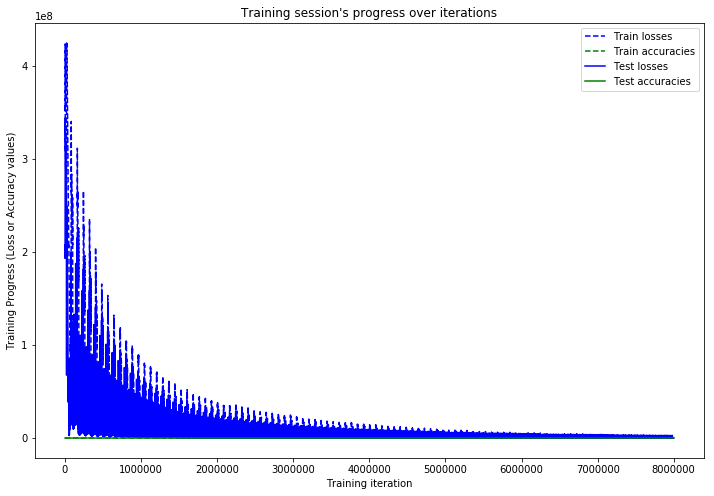

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Testing Accuracy: 100.000011921%

Precision: 96.4297912587%
Recall: 96.7%
f1_score: 96.5151425244%

Confusion Matrix:
[[    0     7     0     0     0     0     1    10     0     0     0     0
      0]
 [    0   756     0     0    27    15    59    43     5     0     0     6
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    31     0     0  2797     0    35    20     1     0     0     7
      0]
 [    0    42     0     0     0   251    20    33     0     0     0     2
      0]
 [    0     9     0     0     0     0 14486     0     0     0     0     0
      0]
 [    0    39     0     0    34    10    74   354    13     0     0    11
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     2     0     0
      0]
 [    0     0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


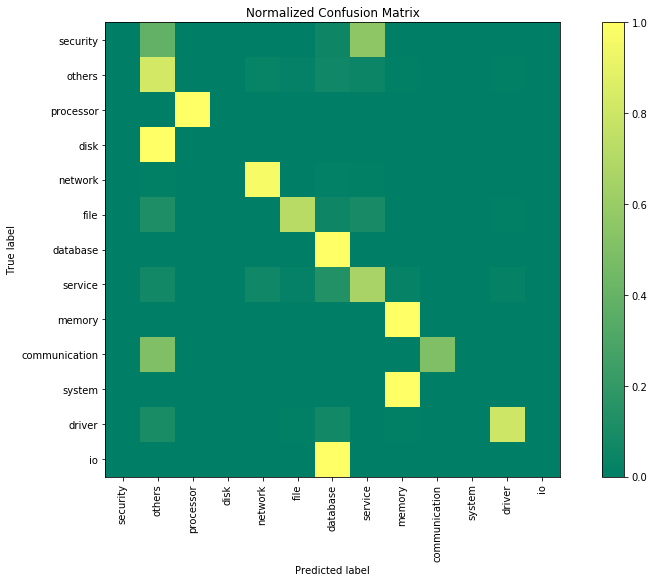

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)